# EN3160 Assignment 2 on Fitting and Alignment

1)

The range of σ values used is [ 1.41  2.83  4.24  5.66  7.07  8.49  9.9  11.31 12.73 14.14].
The parameters of the largest circle are: x=1128.0, y=1439.0, r=42.42640687119285.


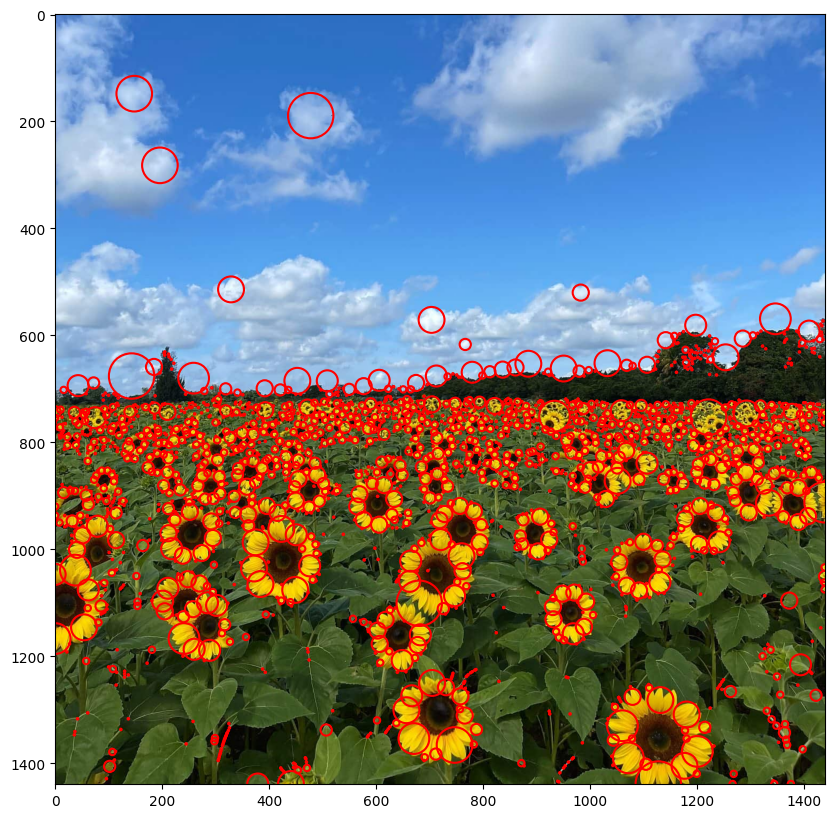

In [25]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import feature

im = cv2.imread('the_berry_farms_sunflower_field.jpeg')
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im_gray = cv2.GaussianBlur(im_gray, (3, 3), 0)

# Compute Laplacian of Gaussian (LoG) images with successively increasing standard deviation and stack them up in a cube
blobs_log = feature.blob_log(im_gray, max_sigma=30, num_sigma=10, threshold=0.12)

# Report the range of σ values used
sigma_range = np.round(np.arange(1, 11, 1) * np.sqrt(2), 2)
print(f"The range of σ values used is {sigma_range}.")

# Report the parameters of the largest circles
if len(blobs_log) > 0:
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
    largest_blob = blobs_log[np.argmax(blobs_log[:, 2])]
    print(f"The parameters of the largest circle are: x={largest_blob[1]}, y={largest_blob[0]}, r={largest_blob[2]}.")
else:
    print("No circle detected.")

# Draw detected blobs as circles on the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
plt.show()


2)

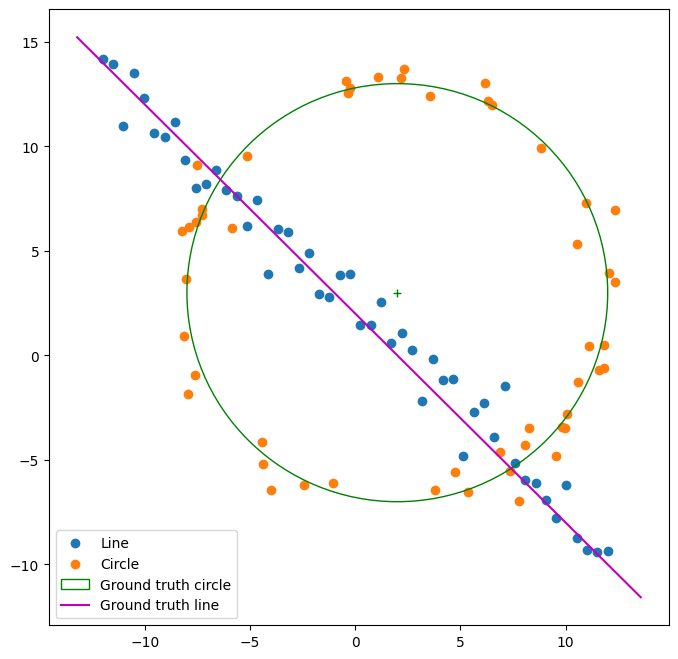

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16

# Generate points for a circle
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Parameters for the line
s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Combine points from the circle and line
X = np.vstack((X_circ, X_line))

# Create a plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

# Ground truth line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()


The estimated line is: a=0.7053241680306145, b=0.7088849159234013, d=1.4448810933310177


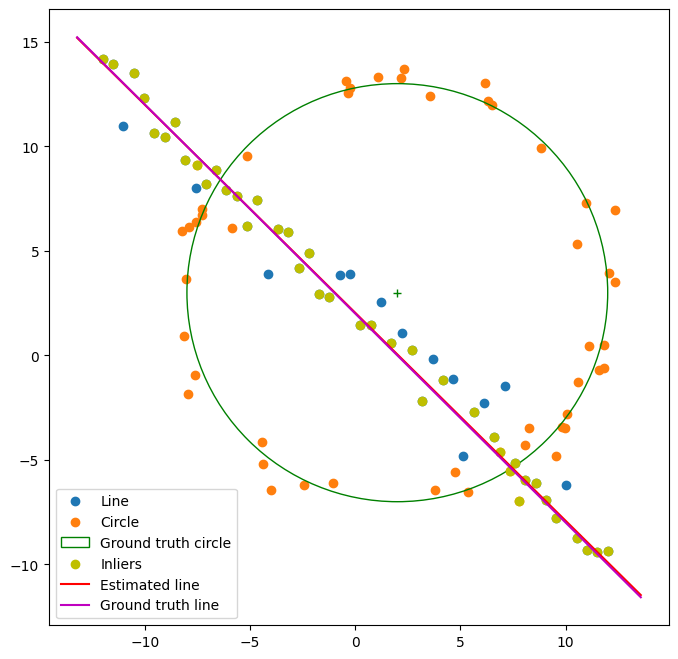

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

# Parameters
N = X.shape[0]
X_=X

# Function to compute the line equation from two points
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a * X_[indices, 0] + b * X_[indices, 1] - d))

# Constraint function
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

# Compute the consensus (inliers)
def consensus_line(X_, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a * X_[:, 0] + b * X_[:, 1] - d)
    return error < t

# RANSAC algorithm to fit a line
def ransac_line(X, t, max_iterations, min_inliers_ratio):
    n = X.shape[0]
    best_error = np.inf
    best_sample_line = []
    res_only_with_sample = []
    best_inliers_line = []

    for i in range(max_iterations):
        # Randomly sample 2 points
        indices = np.random.choice(n, 2, replace=False)
        x0 = [1, 1, 1]
        res = minimize(fun=line_tls, args=indices, x0=x0, tol=1e-6, constraints=cons, options={'disp': False})

        # Compute consensus
        inliers = consensus_line(X, res.x, t)

        # Compute the number of inliers
        n_inliers = np.sum(inliers)

        if n_inliers > min_inliers_ratio * X.shape[0]:
            x0 = res.x
            res = minimize(fun=line_tls, args=inliers, x0=x0, tol=1e-6, constraints=cons, options={'disp': False})
            
            if res.fun < best_error:
                best_error = res.fun
                best_inliers_line = inliers
                best_a, best_b, best_d = res.x
                best_sample_line = indices
                res_only_with_sample = x0

    return best_a, best_b, best_d, best_inliers_line, best_sample_line, res_only_with_sample

# Run RANSAC to fit a line
best_a, best_b, best_d, best_inliers_line, best_sample_line, res_only_with_sample = ransac_line(X, 0.8, 1000, 0.4)

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')
ax.scatter(X[best_inliers_line, 0], X[best_inliers_line, 1], color='y', label='Inliers')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_a / best_b) * x_ + best_d / best_b
# We can characterize a line with three parameters a,b,d where [a,b]⊺ is the unit normal to the line adn d is the perpendicular distance from the origin
print("The estimated line is: a={}, b={}, d={}".format(best_a, best_b, best_d))


plt.plot(x_, y_est, color='r', label='Estimated line')
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()


1.9434751758348743 3.231844856278059 10.08026514922758


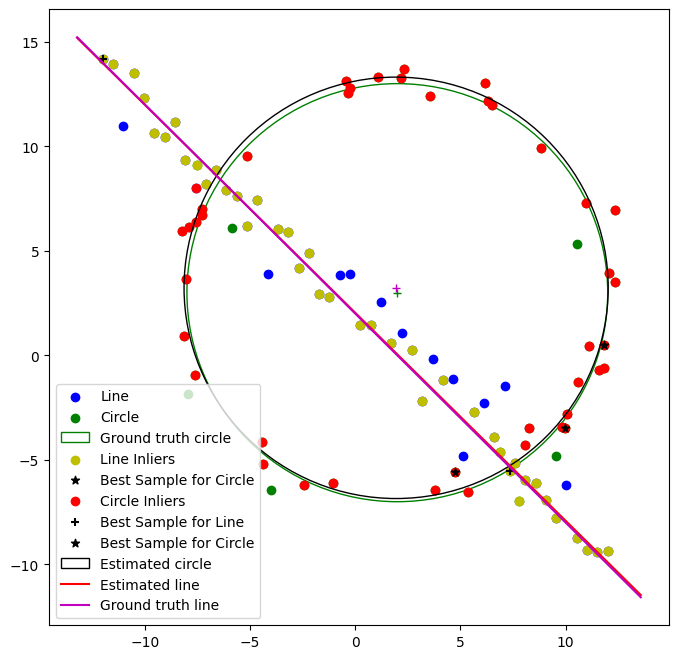

In [24]:
# get remaining points

remaining_points = X[best_inliers_line == False]

def circle_tls(x, indices, remaining_points):
    x_center, y_center, r = x[0], x[1], x[2]
    # Calculate the squared differences between the distances and the circle's radius
    squared_errors = (remaining_points[indices, 0] - x_center)**2 + (remaining_points[indices, 1] - y_center)**2 - r**2
    # Return the sum of squared errors
    return np.sum(np.square(squared_errors))


def consensus_circle(data, model, threshold_inside, threshold_outside):
    a, b, r = model[0], model[1], model[2]
    # Calculate the Euclidean distance between data points and the circle's center
    center = np.array([a, b])
    distances = np.linalg.norm(data - center, axis=1)
    # Return the indices of the inliers w.r.t the given thresholds
    return np.logical_and(distances < threshold_inside + r, distances > r - threshold_outside)

# RANSAC algorithm to fit a circle
def ransac_circle(X, t, max_iterations, min_inliers_ratio):
    n = X.shape[0]
    best_error = np.inf
    best_sample_circle = []
    res_only_with_sample = []
    best_inliers_circle = []
    best_a, best_b, best_r = None, None, None  # Initialize the variables

    for i in range(max_iterations):
        # Randomly sample 3 points
        indices = np.random.choice(n, 3, replace=False)
        x0 = [1, 1, 1]
        res = minimize(fun=circle_tls, args=(indices, remaining_points), x0=x0, tol=1e-6, options={'disp': False})

        # Compute consensus
        inliers = consensus_circle(X, res.x, t, t)

        # Compute the number of inliers
        n_inliers = np.sum(inliers)

        if n_inliers > min_inliers_ratio * X.shape[0]:
            x0 = res.x
            res = minimize(fun=circle_tls, args=(inliers, remaining_points), x0=x0, tol=1e-6, options={'disp': False})
            
            if res.fun < best_error:
                best_error = res.fun
                best_inliers_circle = inliers
                best_a, best_b, best_r = res.x  # Update the best parameters
                best_sample_circle = indices
                res_only_with_sample = x0

    return best_a, best_b, best_r, best_inliers_circle, best_sample_circle, res_only_with_sample



best_x_center, best_y_center, best_r, best_inliers_circle, best_sample_circle, res_only_with_sample = ransac_circle(remaining_points, 1, 500, 0.7  )
print(best_x_center, best_y_center, best_r)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for points
ax.scatter(X_line[:, 0], X_line[:, 1], color='b', label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color='g', label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

# Inliers for line
ax.scatter(X[best_inliers_line, 0], X[best_inliers_line, 1], color='y', label='Line Inliers')

# Inliers for circle
#ax.scatter(remaining_points[best_inliers_circle, 0], remaining_points[best_inliers_circle, 1], color='r', label='Circle Inliers')

# Estimated circle
circle_est = plt.Circle((best_x_center, best_y_center), best_r, color='k', fill=False, label='Estimated circle')

#plotting the best sample
ax.scatter(X[best_sample_circle, 0], X[best_sample_circle, 1], color='k', label='Best Sample for Circle',marker= '*')

# circle inliers   plot
ax.scatter(remaining_points[best_inliers_circle, 0], remaining_points[best_inliers_circle, 1], color='r', label='Circle Inliers')

#plotting the best sample for line
ax.scatter(X[best_sample_line, 0], X[best_sample_line, 1], color='k', label='Best Sample for Line',marker= '+')

ax.scatter(X[best_sample_circle, 0], X[best_sample_circle, 1], color='k', label='Best Sample for Circle',marker= '*')
# plot the remaining points
#ax.scatter(remaining_points[:, 0], remaining_points[:, 1], color='k', label='Remaining Points',marker="x")

ax.add_patch(circle_est)
ax.plot(best_x_center, best_y_center, '+', color='m')

# Estimated line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_a / best_b) * x_ + best_d / best_b
plt.plot(x_, y_est, color='r', label='Estimated line')

# Ground truth line
plt.plot(x_, y_, color='m', label='Ground truth line')

# Legend
plt.legend()
plt.show()


3)

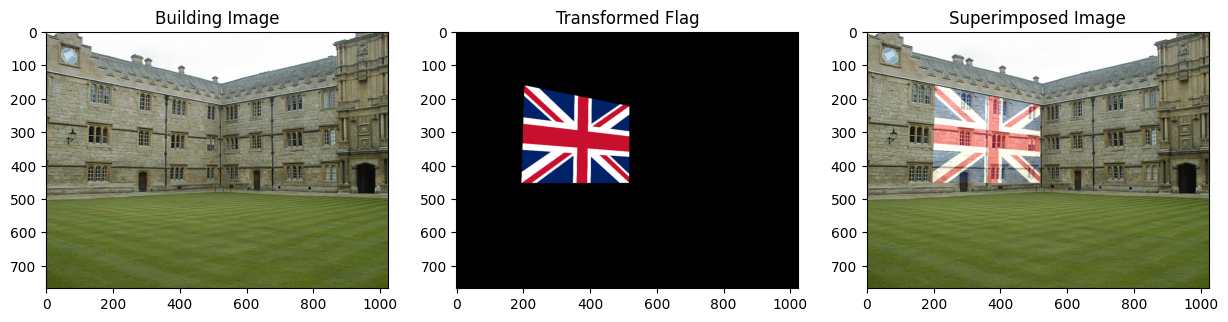

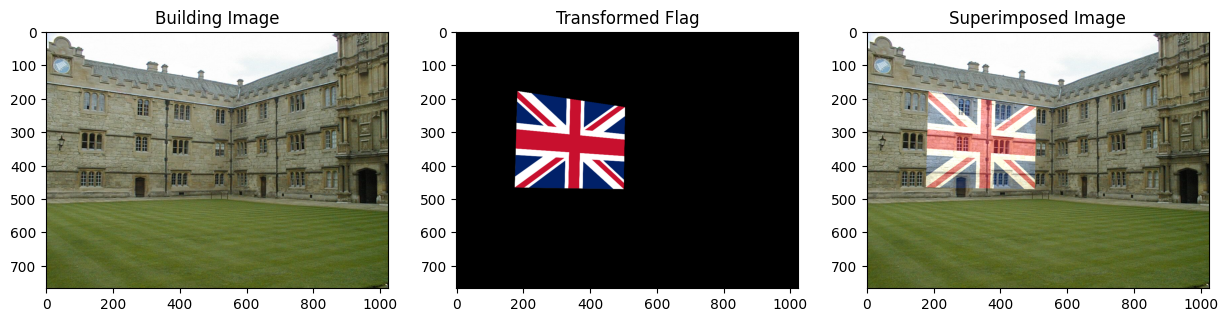

In [98]:
corners = []
def mouse_click(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        corners.append([x,y])

ims = ["001.jpg", "002.jpg"]
for i in range(2):
    im = cv.imread(ims[i])
    background_image=cv.cvtColor(im, cv.COLOR_BGR2RGB)
    image1=cv.imread(ims[i])
    cv.imshow("Wadham College", im)
    corners = []
    cv.setMouseCallback("Wadham College", mouse_click), cv.waitKey(0), cv.destroyAllWindows()
    flag_image = cv.imread("flag.png")
    pts_architecture = np.array(corners, dtype=np.float32)
    pts_flag = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)

    homography_matrix, _ = cv.findHomography(pts_flag, pts_architecture)
    flag_warped = cv.warpPerspective(flag_image, homography_matrix, (background_image.shape[1], background_image.shape[0]))
    flag=cv.cvtColor(flag_warped, cv.COLOR_RGB2BGR)
    alpha = 0.5

    composite_image = cv.addWeighted(im, 1, flag_warped, alpha, 0, dst=background_image)
    composite=cv.cvtColor(composite_image, cv.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1,3,figsize=(15,15))
    ax[0].imshow(cv.cvtColor(image1,cv.COLOR_BGR2RGB)), ax[0].set_title("Building Image")
    ax[1].imshow(cv.cvtColor(flag_warped,cv.COLOR_BGR2RGB)), ax[1].set_title("Transformed Flag")
    ax[2].imshow(cv.cvtColor(composite_image,cv.COLOR_BGR2RGB)), ax[2].set_title("Superimposed Image")
    plt.show()

4)

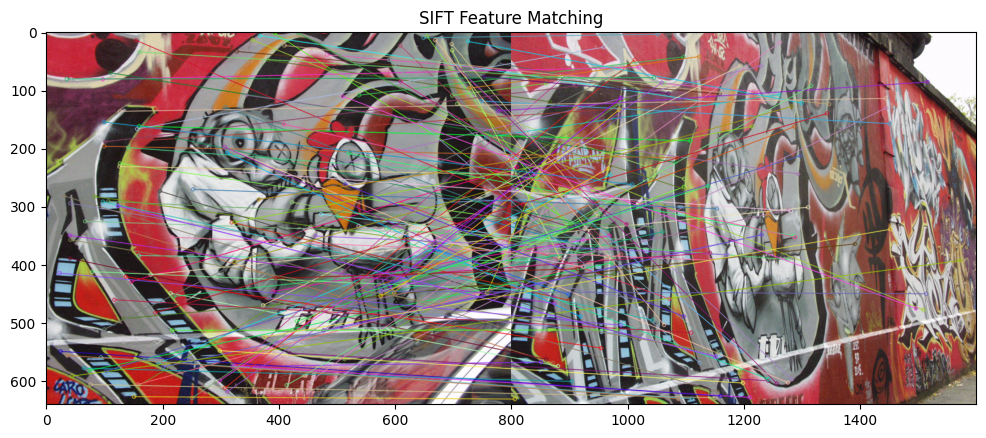

In [128]:
import cv2 as cv
import matplotlib.pyplot as plt


image1, image5 = cv.imread("img1.ppm"), cv.imread("img5.ppm")

sift = cv.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints5, descriptors5 = sift.detectAndCompute(image5, None)
bf_matcher = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
matches = bf_matcher.match(descriptors1, descriptors5)
matches = sorted(matches, key=lambda x: x.distance)
num_matches_to_display = 150
image_with_matches = cv.drawMatches(image1, keypoints1, image5, keypoints5, matches[:num_matches_to_display], image5, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, ax = plt.subplots(figsize=(12, 12))
image_with_matches = cv.cvtColor(image_with_matches, cv.COLOR_BGR2RGB)
ax.set_title("SIFT Feature Matching")
ax.imshow(image_with_matches)
plt.show()

Computed Homography =  [[ 6.23063561e-01  4.13776276e-02  2.24279402e+02]
 [ 2.19153565e-01  1.13392175e+00 -1.93499670e+01]
 [ 4.98162649e-04 -8.42815616e-05  1.00000000e+00]]
Provided Homography =     6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



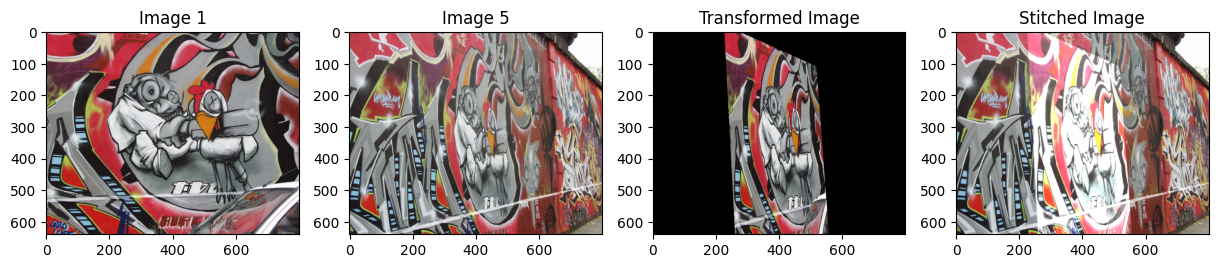

In [125]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the images
image1, image5 = cv.imread("img1.ppm"), cv.imread("img5.ppm")
gray1, gray5 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY), cv.cvtColor(image5, cv.COLOR_BGR2GRAY)

images = [gray1, *(cv.cvtColor(cv.imread(f"img{i}.ppm"), cv.COLOR_BGR2GRAY) for i in range(2, 6))]


def random_sample(n, t):
    sample_indices = np.random.randint(n, size=t)
    sample_counts = np.zeros(np.shape(sample_indices))
    
    for i in range(len(sample_indices)):
        sample_counts[i] = np.sum(sample_indices == sample_indices[i])
    if np.sum(sample_counts) == len(sample_counts):
        return sample_indices
    else:
        return random_sample(n, t)

def ComputeHomography(src_pts, dst_pts):
    x1, y1, x2, y2, x3, y3, x4, y4 = dst_pts[0], dst_pts[1], dst_pts[2], dst_pts[3], dst_pts[4], dst_pts[5], dst_pts[6], dst_pts[7] 
    x1T, x2T, x3T, x4T = src_pts[0], src_pts[1], src_pts[2], src_pts[3]
    zero_matrix = np.array([[0], [0], [0]])

    matrix_A = np.concatenate((np.concatenate((zero_matrix.T,x1T, -y1*x1T), axis = 1), np.concatenate((x1T, zero_matrix.T, -x1*x1T), axis = 1),
                            np.concatenate((zero_matrix.T,x2T, -y2*x2T), axis = 1), np.concatenate((x2T, zero_matrix.T, -x2*x2T), axis = 1),
                            np.concatenate((zero_matrix.T,x3T, -y3*x3T), axis = 1), np.concatenate((x3T, zero_matrix.T, -x3*x3T), axis = 1),
                            np.concatenate((zero_matrix.T,x4T, -y4*x4T), axis = 1), np.concatenate((x4T, zero_matrix.T, -x4*x4T), axis = 1)), axis = 0, dtype=np.float64)
    W, v = np.linalg.eig(((matrix_A.T)@matrix_A))
    temp_H = v[:,np.argmin(W)]
    H = temp_H.reshape((3,3))
    return H

p, s, e = 0.99, 4, 0.5
N = int(np.ceil(np.log(1-p)/np.log(1-((1-e)**s))))
Hs = []
for i in range(4):
    sift = cv.SIFT_create()
    key_points_1, descriptors_1 = sift.detectAndCompute(images[i], None)
    key_points_2, descriptors_2 = sift.detectAndCompute(images[i+1], None)
    bf_match = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
    matches = sorted(bf_match.match(descriptors_1, descriptors_2), key=lambda x: x.distance)

    Source_Points = [key_points_1[k.queryIdx].pt for k in matches]
    Destination_Points = [key_points_2[k.trainIdx].pt for k in matches]
    threshold, best_inliers, best_H = 2, 0, 0

    for i in range(N):
        ran_points = random_sample(len(Source_Points)-1, 4)
        f_points, t_points = [], []
        for j in range(4):
            f_points.append(np.array([[Source_Points[ran_points[j]][0], Source_Points[ran_points[j]][1], 1]]))
            t_points.extend([Destination_Points[ran_points[j]][0], Destination_Points[ran_points[j]][1]])

        H = ComputeHomography(f_points, t_points)
        
        inliers = 0 
        for k in range(len(Source_Points)):
            X = [Source_Points[k][0], Source_Points[k][1], 1]
            HX = H @ X
            HX /= HX[-1]
            err = np.sqrt(np.power(HX[0]-Destination_Points[k][0], 2) + np.power(HX[1]-Destination_Points[k][1], 2))
            if err < threshold:
                inliers += 1
        if inliers > best_inliers:
            best_inliers = inliers
            best_H = H 
    Hs.append(best_H)

H1_H5 = Hs[3] @ Hs[2] @ Hs[1] @ Hs[0]
H1_H5 /= H1_H5[-1][-1]

print("Computed Homography = ", H1_H5)
print("Provided Homography = ", open("H1to5p",'r').read())

transformed_img1 = cv.warpPerspective(image1, H1_H5, (np.shape(image5)[1], np.shape(image5)[0]))
stitched_img = cv.add(image5, transformed_img1)

fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(cv.cvtColor(image1, cv.COLOR_BGR2RGB)), ax[0].set_title("Image 1")
ax[1].imshow(cv.cvtColor(image5, cv.COLOR_BGR2RGB)), ax[1].set_title("Image 5")
ax[2].imshow(cv.cvtColor(transformed_img1, cv.COLOR_BGR2RGB)), ax[2].set_title("Transformed Image")
ax[3].imshow(cv.cvtColor(stitched_img, cv.COLOR_BGR2RGB)), ax[3].set_title("Stitched Image")
plt.show()
